Init Model

#### Imports
---

In [50]:
# imports for the practice (you can add more if you need)
import os
import sys
from tqdm import tqdm
import torchviz
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
# %matplotlib notebook
%matplotlib inline

# project directory to the Python path
project_path = "MRI_Barin_Alzheimer_Classification"
if project_path not in sys.path:
    sys.path.append(project_path)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f'torch.cuda.is_available(): {cuda_available}') 

# Check cuda version
print(torch.version.cuda)  


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

torch.cuda.is_available(): True
12.1


#### Load The Data
---

In [51]:
# Define the directory containing the dataset
data_dir = '../data/raw'


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),  # Convert images to tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


#### Seperate the train , validation and test
---

In [52]:
# Shuffle and split the dataset
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print the sizes of each dataset
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 4480
Validation set size: 960
Test set size: 960


#### load data into dataloaders
---

In [53]:
# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#### show a sample of train,validation and test
---

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\multiprocessing\queues.py", line 235, in _feed
    close()
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\multiprocessing\queues.py", line 266, in _feed
    queue_sem.release()
Val

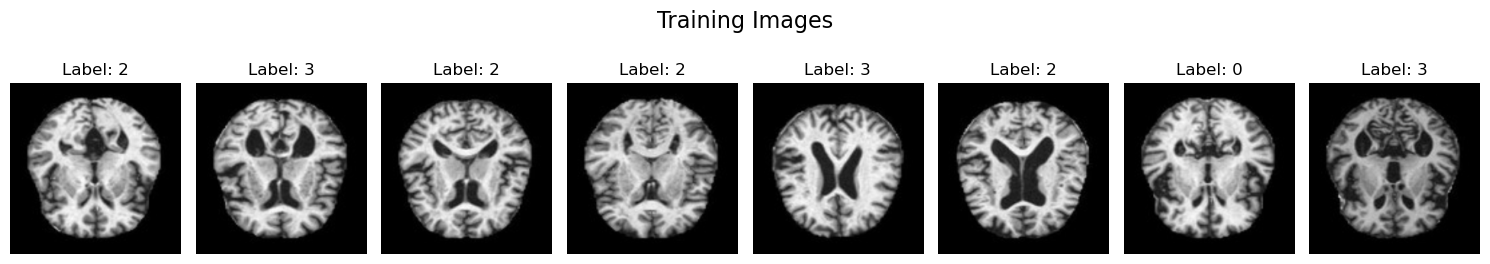

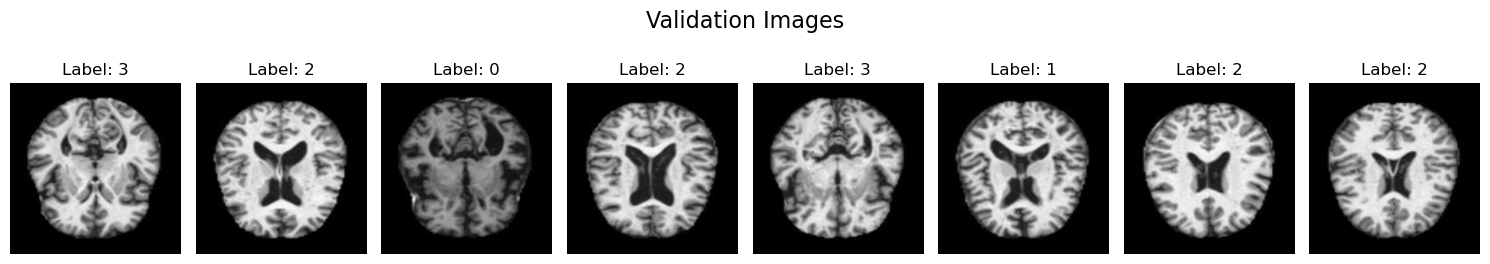

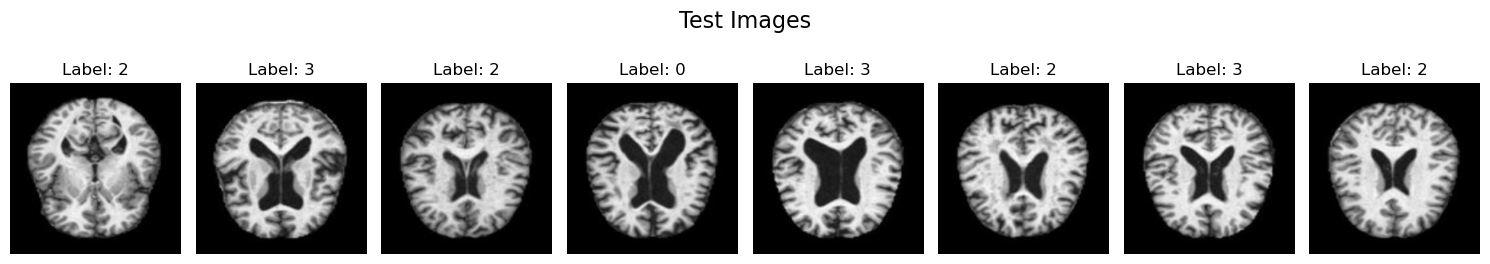

In [54]:
# Function to show a batch of images
def show_images(loader, title):
    # Get a batch of images and labels
    images, labels = next(iter(loader))
    
    # Create a grid of images
    grid_size = min(len(images), 8)
    fig, axes = plt.subplots(1, grid_size, figsize=(15, 3))  # Adjusted figure size for compact layout
    for i in range(grid_size):
        image = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {labels[i].item()}')
    
    plt.tight_layout()  # Adjust the layout to be compact
    fig.suptitle(title, fontsize=16)  # Add a main title with larger font size
    plt.subplots_adjust(top=0.85)  # Adjust the top to fit the title
    plt.show()

# Show images from each group
show_images(train_loader, 'Training Images')
show_images(val_loader, 'Validation Images')
show_images(test_loader, 'Test Images')

#### Class Definition
---

In [55]:
import torch
import torch.nn as nn

class SimpleMRI(nn.Module):
    """ CNN for the MRI Brain Alzheimer dataset """
    def __init__(self, input_channels=3, output_channels=10):
        """ CNN Builder """
        super(SimpleMRI, self).__init__()
        
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size = 112 x 112

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size = 56 x 56
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size = 28 x 28
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size = 14 x 14
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(256 * 14 * 14, 1024),  # 256 * 14 * 14 = 50176
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, output_channels)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


#### Utils
---

In [56]:
# Initialize the CNN classifier
input_channels = 3
output_channels = 10
model = SimpleMRI(input_channels, output_channels)

# print info regards the CNN model
# number of parameters
num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

# model size
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024 ** 2
print(f"model size: {size_all_mb:.2f} MB")


# hyper-parameters
batch_size = 256
learning_rate = 1e-4
epochs = 20

# loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=False, num_workers=4)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using the device: {device}")
model.to(device)

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num trainable weights:  53038090
model size: 202.32 MB
Using the device: cuda:0


#### Calculate accuracy
---

In [57]:
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10, 10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

#### Train
---

In [58]:
# training loop
epoch_losses = []

for epoch in range(1, epochs + 1):
    model.train()  # traning mode - dropout activated
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # augmentation with `kornia` happens here inputs = aug_list(inputs)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)  # Append to list

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # log = "Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% | Epoch Time: {epoch_time:.2f} secs"
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}%  | Test accuracy: {:.3f}% | ".format(epoch, epoch_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)

    print(log)
    
    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/cifar_cnn_ckpt.pth')

print('==> Finished Training ...')


#### Plot results
---

In [ ]:
# plot the loss of each epoch
_, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(1, epochs + 1), epoch_losses, color='red')  # Plotting in red color
ax.set_title('Train Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True) 